In [2]:
import numpy as np 
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

import os
print(os.listdir("../input"))

['dogs-vs-cats']


# # ****Prepare Training Data****

In [68]:
filenames = os.listdir("/kaggle/working/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append("1")
    else:
        categories.append("0")

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df

filename category
0       dog.7205.jpg        1
1       cat.6938.jpg        0
2       cat.1082.jpg        0
3       cat.4989.jpg        0
4       cat.8836.jpg        0
...              ...      ...
24995   dog.3084.jpg        1
24996   dog.6443.jpg        1
24997   cat.8569.jpg        0
24998   cat.6792.jpg        0
24999  cat.10696.jpg        0

[25000 rows x 2 columns]

<Axes: >

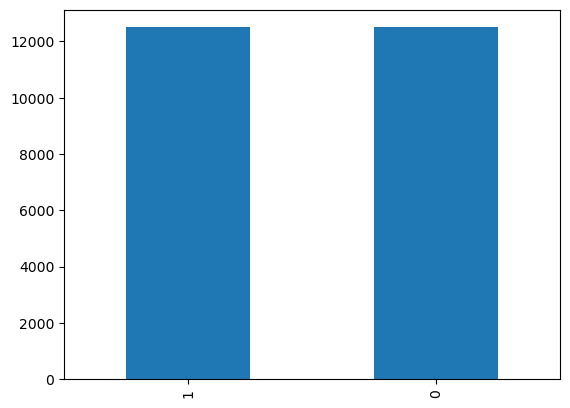

In [26]:
df['category'].value_counts().plot.bar()

'cat'

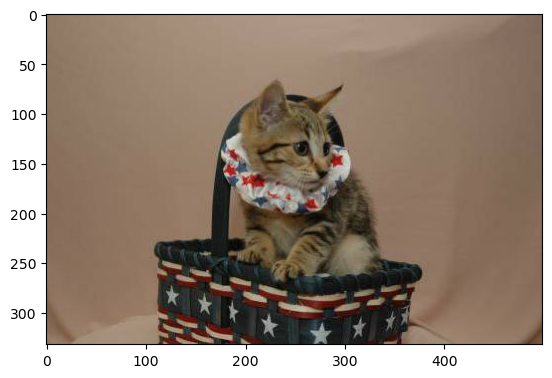

In [71]:
sample = random.choice(filenames)
image = load_img("/kaggle/working/train/"+sample)
plt.imshow(image)
sample.split('.')[0]

# # **Build Model**

In [38]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import plot_model
from keras.applications import VGG16
from keras.models import Model

image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 5
batch_size = 16

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
x = GlobalMaxPooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['acc'])

model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


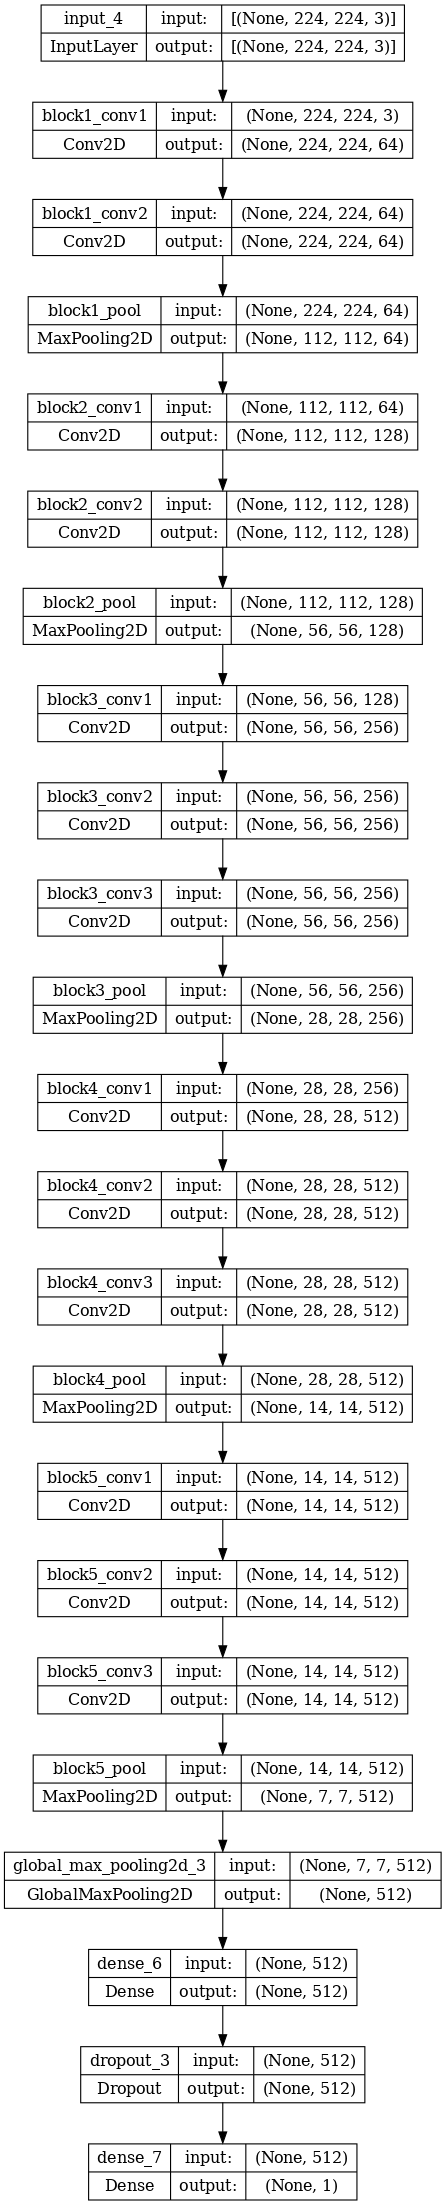

In [39]:
plot_model(model, show_shapes = True,expand_nested = True,dpi = 80)

In [30]:
train_df, validate_df = train_test_split(df, test_size=0.1)
train_df = train_df.reset_index()
validate_df = validate_df.reset_index()


total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

# # **Data Augmentation**

In [31]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/kaggle/working/train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/kaggle/working/train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 22500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


Found 1 validated image filenames.


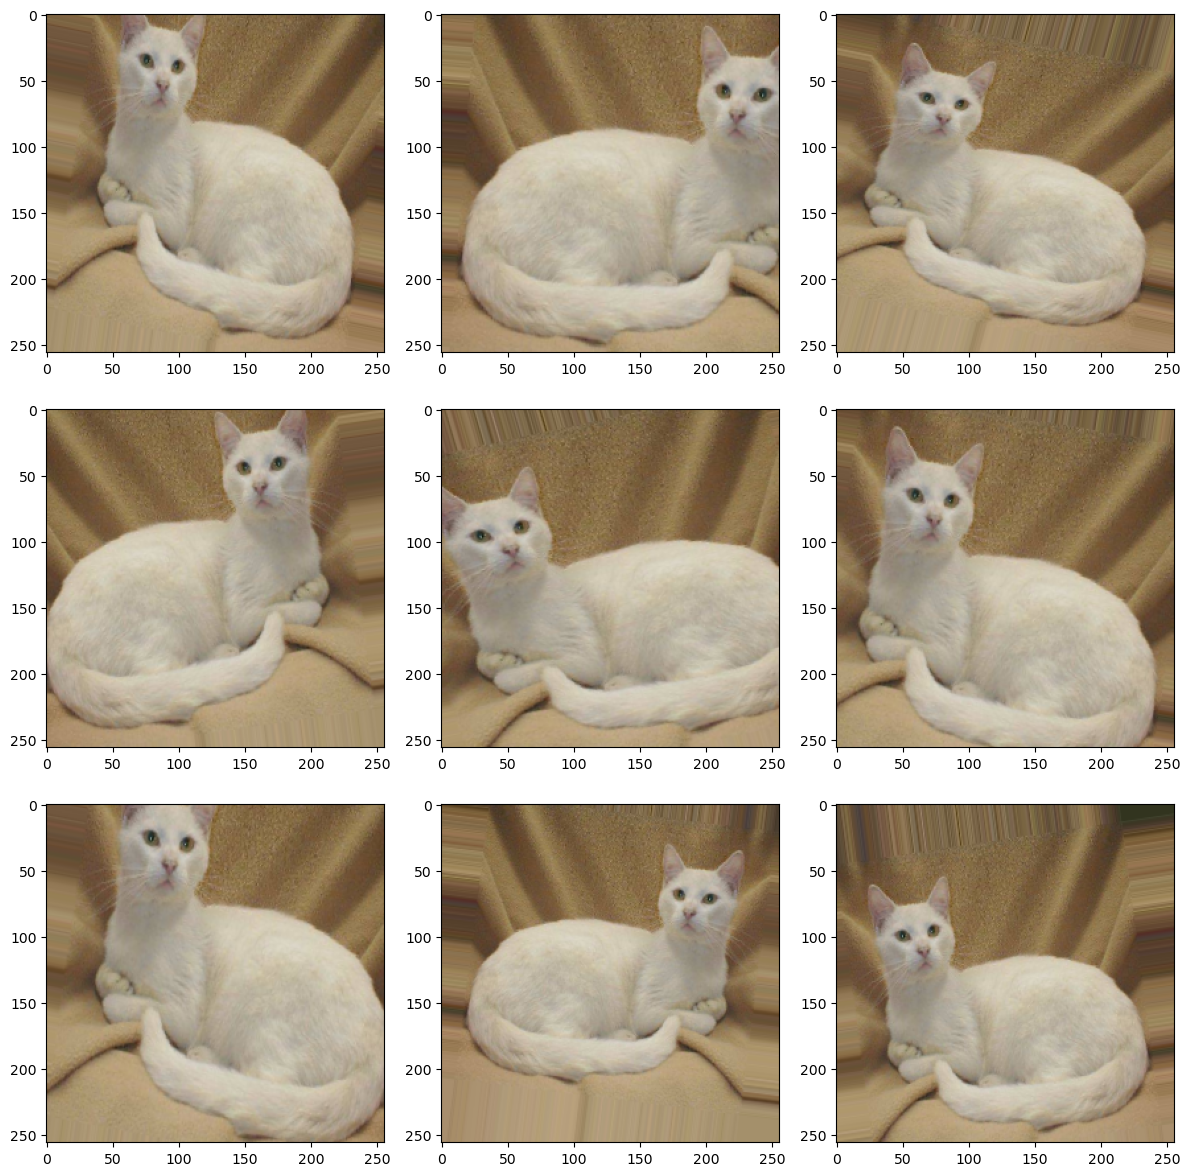

In [32]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/kaggle/working/train", 
    x_col='filename',
    y_col='category',
    class_mode='input'
)
plt.figure(figsize=(12, 12))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# # **Fit Model**

In [40]:
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size)

/tmp/ipykernel_28/3390919752.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5
1406/1406 [==============================] - 363s 258ms/step - loss: 0.2862 - acc: 0.8664 - val_loss: 0.1513 - val_acc: 0.9363
Epoch 2/5
1406/1406 [==============================] - 362s 258ms/step - loss: 0.1484 - acc: 0.9394 - val_loss: 0.1149 - val_acc: 0.9507
Epoch 3/5
1406/1406 [==============================] - 362s 257ms/step - loss: 0.1274 - acc: 0.9485 - val_loss: 0.0949 - val_acc: 0.9635
Epoch 4/5
1406/1406 [==============================] - 372s 265ms/step - loss: 0.1101 - acc: 0.9544 - val_loss: 0.0969 - val_acc: 0.9619
Epoch 5/5
1406/1406 [==============================] - 369s 262ms/step - loss: 0.1031 - acc: 0.9588 - val_loss: 0.0892 - val_acc: 0.9627


In [41]:
loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

/tmp/ipykernel_28/2489114373.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  loss, accuracy = model.evaluate_generator(validation_generator, total_validate//batch_size, workers=12)


Test: accuracy = 0.962740  ;  loss = 0.089287 


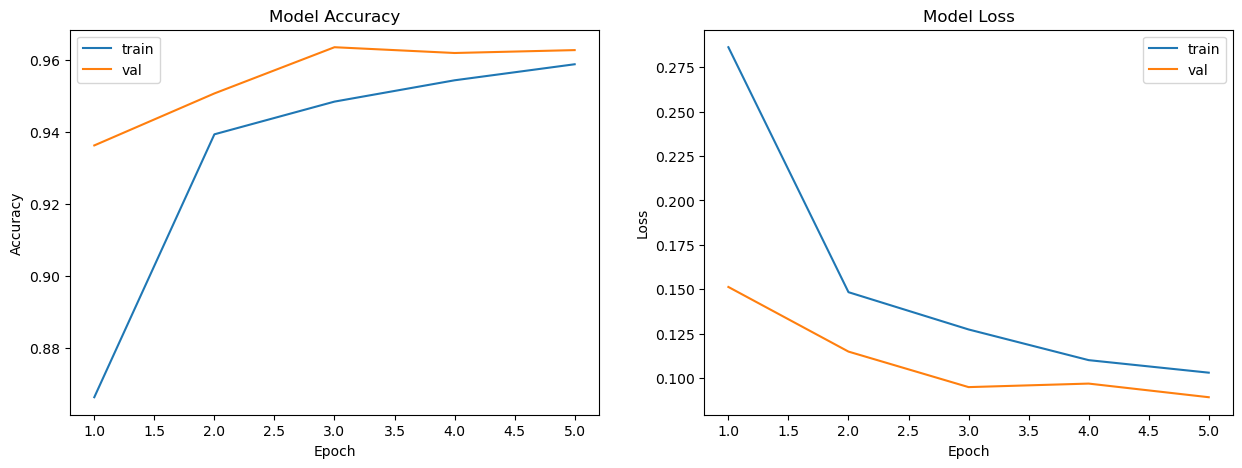

In [44]:
def plot_model_history(model_history, acc='acc', val_acc='val_acc'):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    axs[0].plot(range(1,len(model_history.history[acc])+1),model_history.history[acc])
    axs[0].plot(range(1,len(model_history.history[val_acc])+1),model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'val'], loc='best')
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

In [46]:
Y_val = validate_df['category']
y_pred =  model.predict_generator(validation_generator)

/tmp/ipykernel_28/3041536869.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred =  model.predict_generator(validation_generator)


In [54]:
threshold = 0.5
y_final = np.where(y_pred > threshold, "1","0")

In [55]:
y_final.size

2500

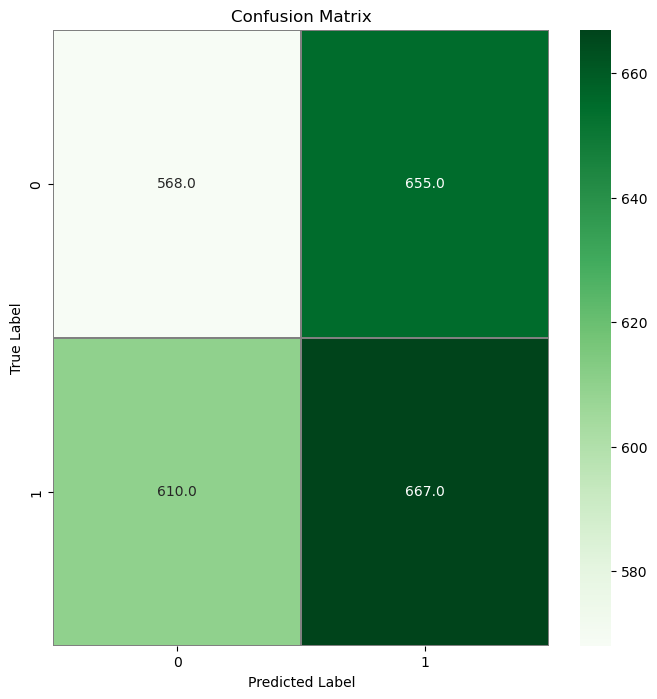

In [56]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val, y_final) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [57]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(Y_val, y_final, target_names=['0','1'])

print(report)

              precision    recall  f1-score   support

           0       0.48      0.46      0.47      1223
           1       0.50      0.52      0.51      1277

    accuracy                           0.49      2500
   macro avg       0.49      0.49      0.49      2500
weighted avg       0.49      0.49      0.49      2500



In [72]:
test_filenames = os.listdir("/kaggle/working/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
test_df

filename
0      8848.jpg
1      8102.jpg
2      5757.jpg
3      5569.jpg
4      3571.jpg
...         ...
12495  3305.jpg
12496  6860.jpg
12497  6923.jpg
12498  1603.jpg
12499  8930.jpg

[12500 rows x 1 columns]

In [61]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/kaggle/working/test1", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    batch_size=batch_size,
    target_size=(image_size, image_size),
    shuffle=False
)

Found 12500 validated image filenames.


# # **Predict**

In [62]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
threshold = 0.5
test_df['category'] = np.where(predict > threshold, 1,0)

/tmp/ipykernel_28/10802553.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


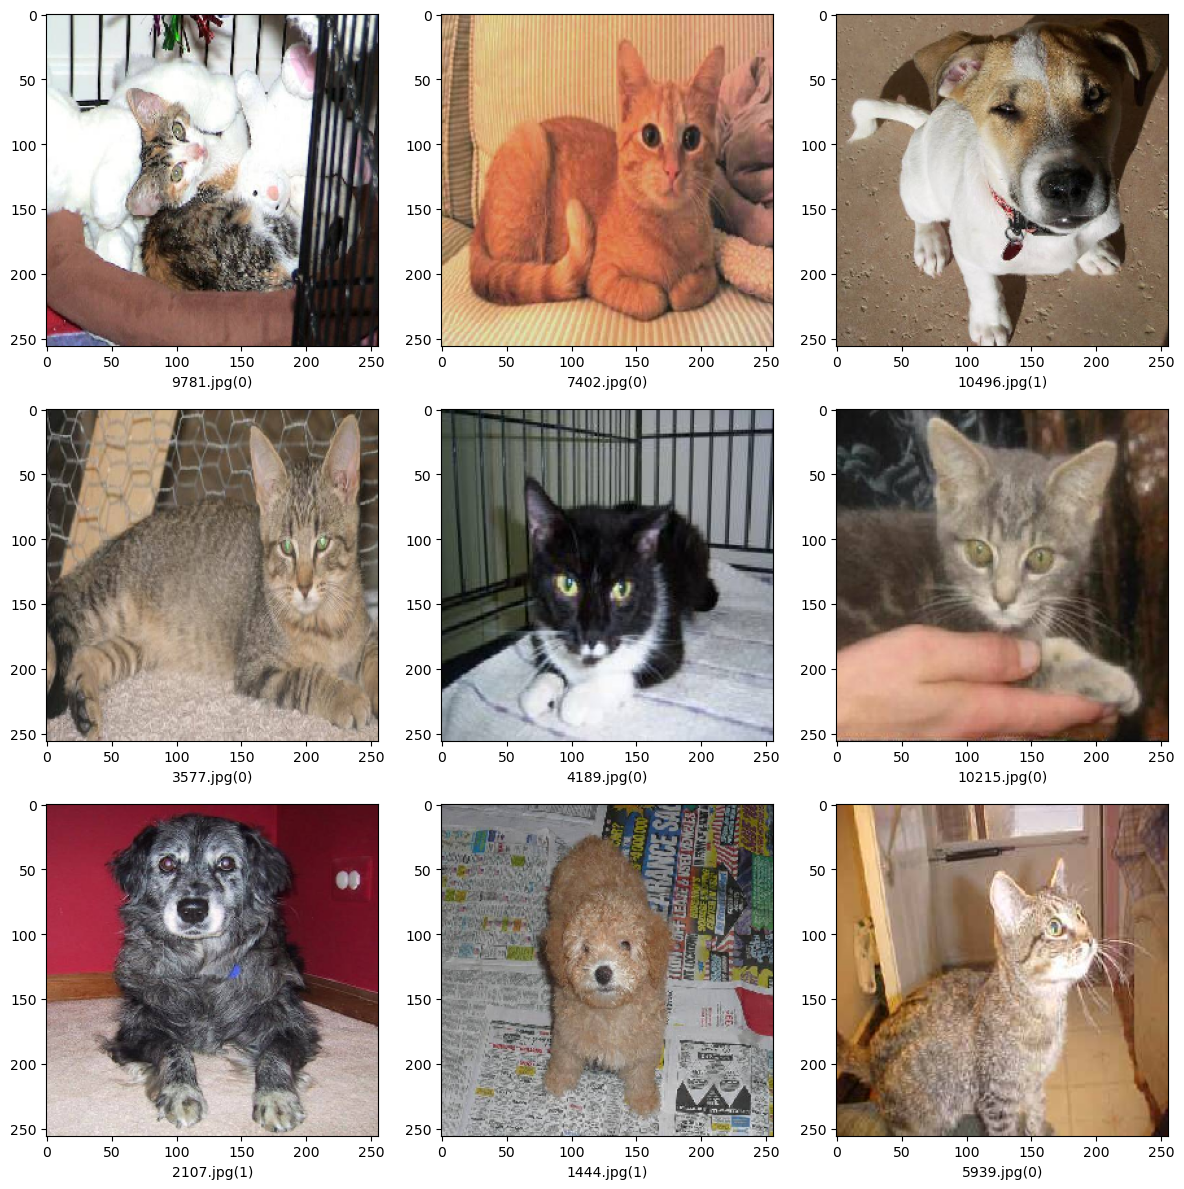

In [63]:
sample_test = test_df.sample(n=9).reset_index()
sample_test.head()
plt.figure(figsize=(12, 12))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/kaggle/working/test1/"+filename, target_size=(256, 256))
    plt.subplot(3, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')')
plt.tight_layout()
plt.show()

In [66]:
model.save('model.h5')